# Housekeeping (Importing libraries, loading datasets)

In [1]:
from utility import random_number_generator as rng
from utility import variance_reduction as vr

import pandas as pd
import numpy as np
from datetime import datetime
import time

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import qmc
from scipy.stats import norm

### SOFR Data Work

In [2]:
# secured overnight financing rate, sourced from the st. louis fred
sofr = pd.read_csv('data/FRED_SOFR.csv', parse_dates=['DATE'], index_col='DATE')

In [3]:
sofr.head()

,SOFR
DATE,
2018-04-03,1.83
2018-04-04,1.74
2018-04-05,1.75
2018-04-06,1.75
2018-04-09,1.75


In [4]:
print(sofr.info())
print(sofr.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1719 entries, 2018-04-03 to 2024-11-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SOFR    1719 non-null   object
dtypes: object(1)
memory usage: 26.9+ KB
None
            SOFR
DATE            
2018-04-03  1.83
2018-04-04  1.74
2018-04-05  1.75
2018-04-06  1.75
2018-04-09  1.75


In [5]:
# Ensure the SOFR column is numeric
sofr['SOFR'] = pd.to_numeric(sofr['SOFR'], errors='coerce')  # Convert to numeric, set invalid entries to NaN

# Drop rows with NaN values in the SOFR column
sofr.dropna(subset=['SOFR'], inplace=True)

# Convert to decimal format (from percentages)
sofr['Rate'] = sofr['SOFR'] / 100

In [6]:
print(sofr.head())

            SOFR    Rate
DATE                    
2018-04-03  1.83  0.0183
2018-04-04  1.74  0.0174
2018-04-05  1.75  0.0175
2018-04-06  1.75  0.0175
2018-04-09  1.75  0.0175


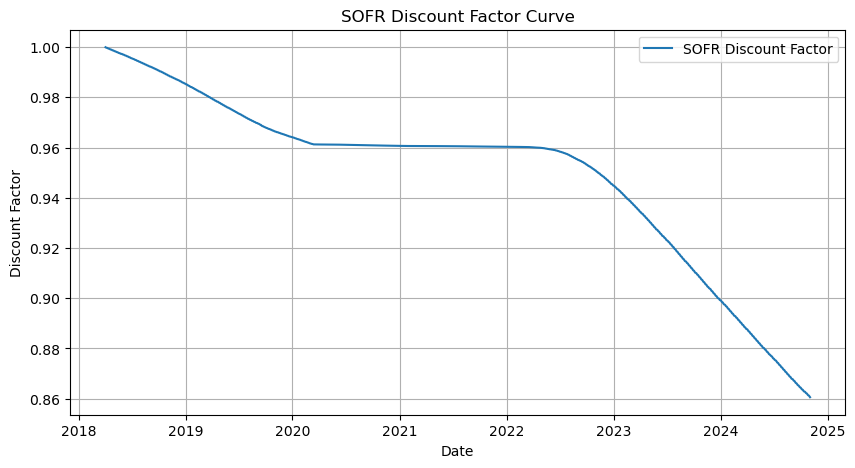

In [7]:
sofr['Rate'] = sofr['SOFR'] / 100  # Convert to decimal format

# Compute cumulative discount factors
dt = 1 / 252  # Daily time step
sofr['Discount_Factor'] = np.exp(-np.cumsum(sofr['Rate'] * dt))

# Plot the SOFR discount factor curve
plt.figure(figsize=(10, 5))
plt.plot(sofr.index, sofr['Discount_Factor'], label="SOFR Discount Factor")
plt.title("SOFR Discount Factor Curve")
plt.xlabel("Date")
plt.ylabel("Discount Factor")
plt.legend()
plt.grid()
plt.show()

### Market Yield Data Work

In [8]:
# Load Market Yield on U.S. Treasury Securities at X-Year Constant Maturity, Quoted on an Investment Basis
dgs1 = pd.read_csv('data/DGS1.csv', parse_dates=['DATE'], index_col='DATE')
dgs2 = pd.read_csv('data/DGS2.csv', parse_dates=['DATE'], index_col='DATE')
dgs5 = pd.read_csv('data/DGS5.csv', parse_dates=['DATE'], index_col='DATE')
dgs10 = pd.read_csv('data/DGS10.csv', parse_dates=['DATE'], index_col='DATE')
dgs30 = pd.read_csv('data/DGS30.csv', parse_dates=['DATE'], index_col='DATE')

# combine them all
yc = pd.concat([dgs1.rename(columns={'DGS1': '1Y'}),
                              dgs2.rename(columns={'DGS2': '2Y'}),
                              dgs5.rename(columns={'DGS5': '5Y'}),
                              dgs10.rename(columns={'DGS10': '10Y'}),
                              dgs30.rename(columns={'DGS30': '30Y'})], axis=1)

# I. Exploratory Data Analysis

In [9]:
# check formissing values and prepare for imputation
print("\nMissing values in SOFR Data:", sofr.isna().sum())
print("Missing values in Yield Curve Data:", yc.isna().sum())


Missing values in SOFR Data: SOFR               0
Rate               0
Discount_Factor    0
dtype: int64
Missing values in Yield Curve Data: 1Y        0
2Y     3760
5Y        0
10Y       0
30Y    3945
dtype: int64


In [10]:
print("\nSOFR Summary Statistics:")
print(sofr.describe())


SOFR Summary Statistics:
              SOFR         Rate  Discount_Factor
count  1647.000000  1647.000000      1647.000000
mean      2.297535     0.022975         0.949605
std       2.014423     0.020144         0.033830
min       0.010000     0.000100         0.860570
25%       0.090000     0.000900         0.936837
50%       1.950000     0.019500         0.960496
75%       4.550000     0.045500         0.965557
max       5.400000     0.054000         0.999927


In [11]:
print("\nYield Curve Summary Statistics:")
print(yc.describe())


Yield Curve Summary Statistics:
           1Y     2Y     5Y    10Y    30Y
count   16393  12633  16393  16393  12448
unique   1896   1873   1468   1403   1323
top         .      .      .      .      .
freq      698    530    698    698    523


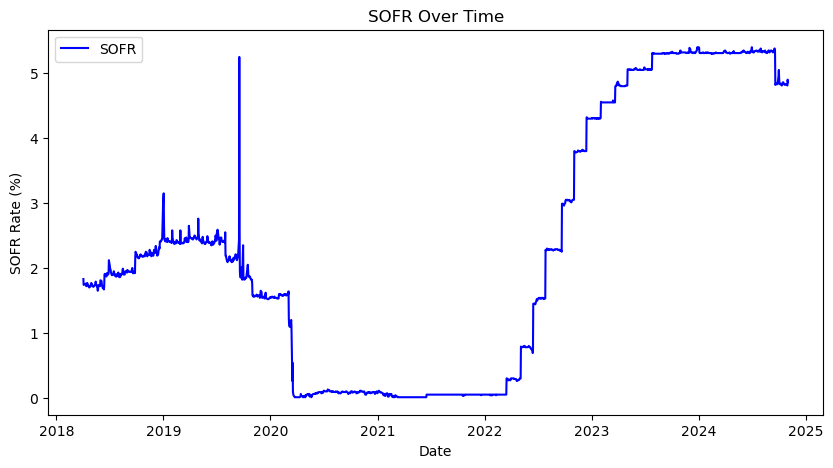

In [12]:
# Ensure SOFR data is numeric and drop any non-numeric rows (if any)
sofr['SOFR'] = pd.to_numeric(sofr['SOFR'], errors='coerce')
sofr = sofr.dropna()  # Drop rows where SOFR might be NaN after conversion

# Plot SOFR over time
plt.figure(figsize=(10, 5))
plt.plot(sofr.index, sofr['SOFR'], label='SOFR', color='blue')
plt.title("SOFR Over Time")
plt.xlabel("Date")
plt.ylabel("SOFR Rate (%)")
plt.legend()
plt.show()

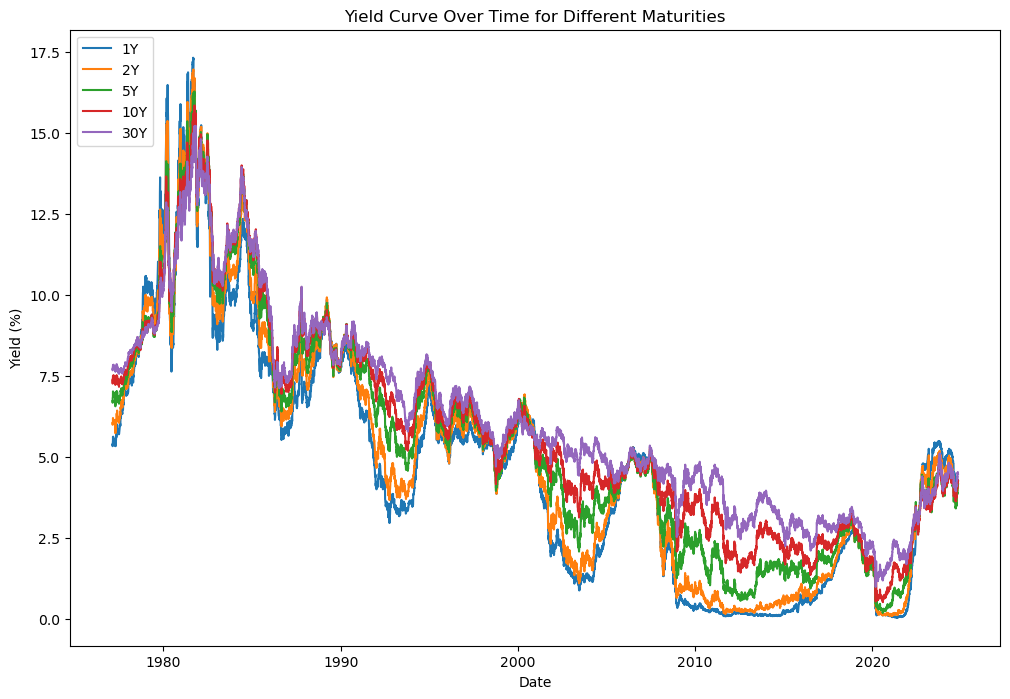

In [13]:
# Ensure all yield curve columns are numeric and handle any non-numeric values
for col in yc.columns:
    yc[col] = pd.to_numeric(yc[col], errors='coerce')

yc = yc.interpolate(method='time').dropna()  # Interpolate missing values based on time index

plt.figure(figsize=(12, 8))
for col in yc.columns:
    plt.plot(yc.index, yc[col], label=col)
    
plt.title("Yield Curve Over Time for Different Maturities")
plt.xlabel("Date")
plt.ylabel("Yield (%)")
plt.legend(loc='upper left')
plt.show()

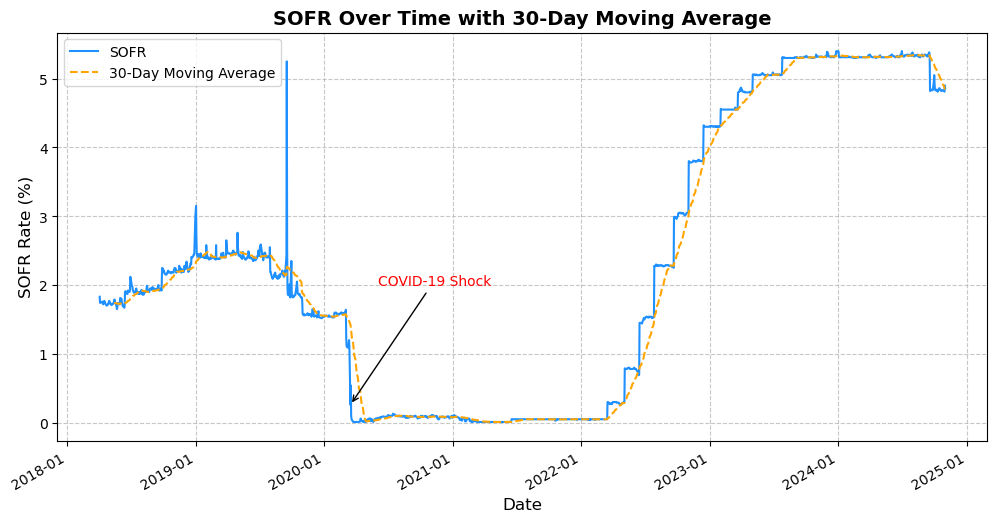

In [14]:
sofr['SOFR'] = pd.to_numeric(sofr['SOFR'], errors='coerce')
sofr = sofr.dropna() 

sofr['SOFR_MA'] = sofr['SOFR'].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(sofr.index, sofr['SOFR'], label='SOFR', color='dodgerblue')
plt.plot(sofr.index, sofr['SOFR_MA'], label='30-Day Moving Average', color='orange', linestyle='--')
annot_date = datetime(2020, 3, 16)
plt.annotate('COVID-19 Shock', 
             xy=(annot_date, sofr.loc[annot_date, 'SOFR']), 
             xytext=(datetime(2020, 6, 1), 2.0),
             arrowprops=dict(facecolor='red', arrowstyle='->'), color='red')

plt.title("SOFR Over Time with 30-Day Moving Average", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("SOFR Rate (%)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()

plt.show()

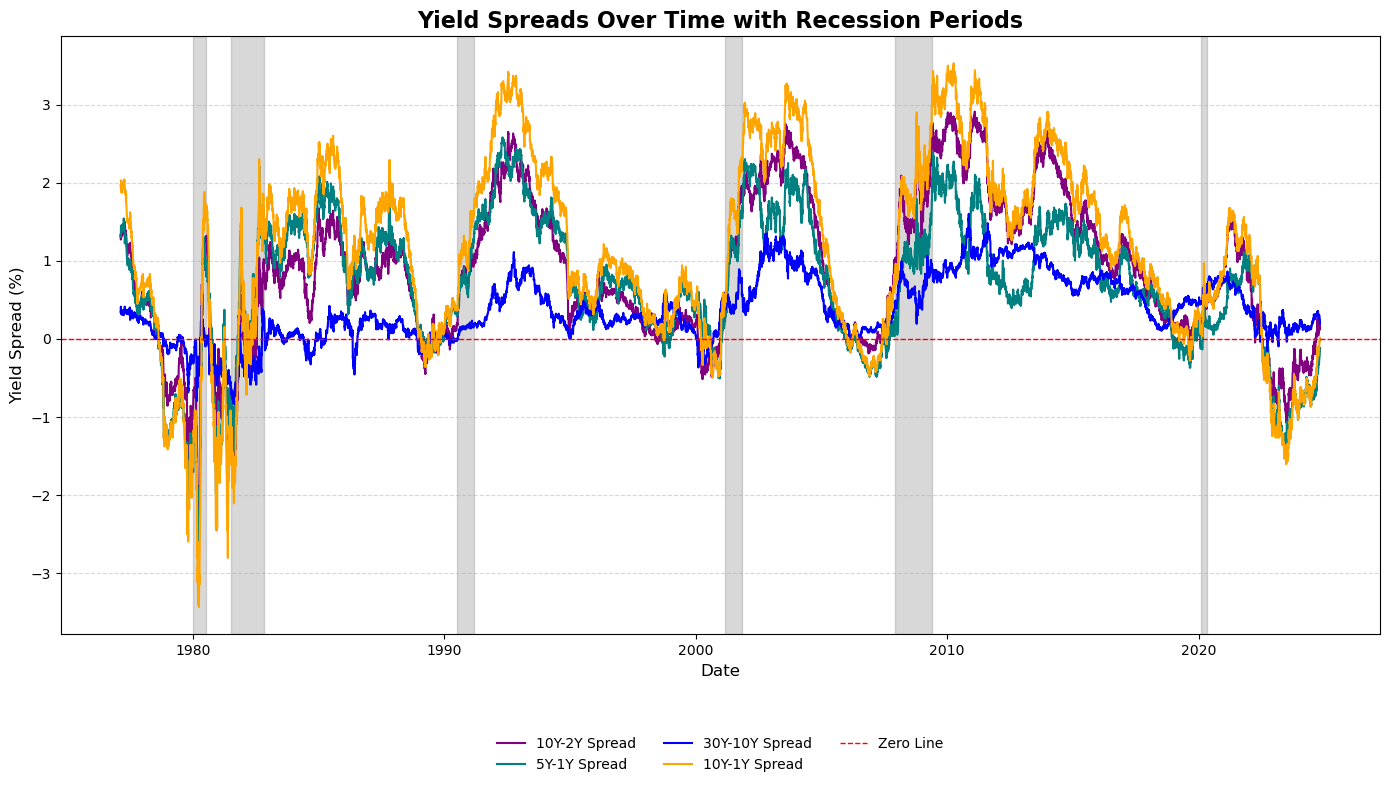

In [15]:
recession_periods = [
    ('1969-12-01', '1970-11-01'),
    ('1973-11-01', '1975-03-01'),
    ('1980-01-01', '1980-07-01'),
    ('1981-07-01', '1982-11-01'),
    ('1990-07-01', '1991-03-01'),
    ('2001-03-01', '2001-11-01'),
    ('2007-12-01', '2009-06-01'),
    ('2020-02-01', '2020-05-01') 
]

start_date = '1975-01-01'
filtered_yc = yc[yc.index >= start_date]
filtered_yc['10Y-2Y Spread'] = filtered_yc['10Y'] - filtered_yc['2Y']
filtered_yc['5Y-1Y Spread'] = filtered_yc['5Y'] - filtered_yc['1Y']
filtered_yc['30Y-10Y Spread'] = filtered_yc['30Y'] - filtered_yc['10Y']
filtered_yc['10Y-1Y Spread'] = filtered_yc['10Y'] - filtered_yc['1Y']

plt.figure(figsize=(14, 8))
plt.plot(filtered_yc.index, filtered_yc['10Y-2Y Spread'], color='purple', label='10Y-2Y Spread')
plt.plot(filtered_yc.index, filtered_yc['5Y-1Y Spread'], color='teal', label='5Y-1Y Spread')
plt.plot(filtered_yc.index, filtered_yc['30Y-10Y Spread'], color='blue', label='30Y-10Y Spread')
plt.plot(filtered_yc.index, filtered_yc['10Y-1Y Spread'], color='orange', label='10Y-1Y Spread')

plt.axhline(0, color='red', linestyle='--', label='Zero Line', linewidth=1)

for start, end in recession_periods:
    if start >= start_date: 
        plt.axvspan(start, end, color='gray', alpha=0.3)

plt.title("Yield Spreads Over Time with Recession Periods", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Yield Spread (%)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=10, frameon=False)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

are all these spreads required to be plotted? whats the significance?

# II: Construction of Forward Rate Curves

Forward Rate Curve:
               1Y-2Y     2Y-5Y    5Y-10Y   10Y-30Y
DATE                                              
1977-02-15  6.694009  7.175754  8.003838  7.870404
1977-02-16  6.643647  7.155755  7.983839  7.835380
1977-02-17  6.654136  7.125755  7.853263  7.875587
1977-02-18  6.744388  7.329690  8.003259  7.935427
1977-02-21  6.728915  7.339630  8.003176  7.942927


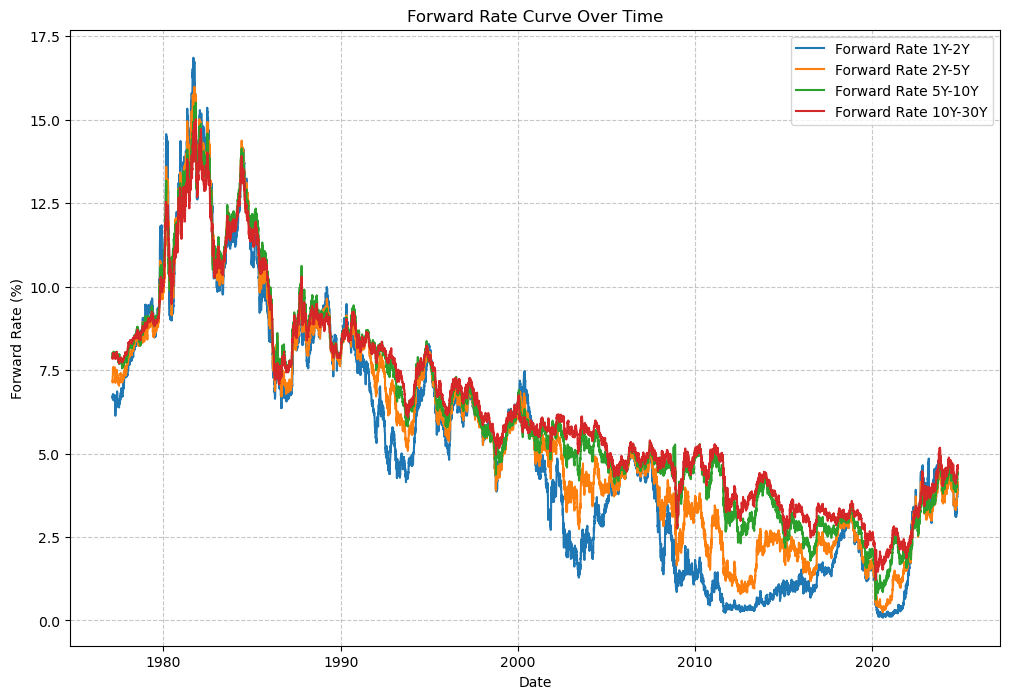

In [16]:
def calculate_forward_rate(yield_curve, t1, t2):
    # Spot rates for maturities t1 and t2
    r_t1 = yield_curve[f"{t1}Y"]
    r_t2 = yield_curve[f"{t2}Y"]
    
    forward_rate = ((1 + r_t2 / 100) ** t2 / (1 + r_t1 / 100) ** t1) ** (1 / (t2 - t1)) - 1
    return forward_rate * 100

forward_curve = pd.DataFrame(index=yc.index)
forward_curve['1Y-2Y'] = calculate_forward_rate(yc, 1, 2)
forward_curve['2Y-5Y'] = calculate_forward_rate(yc, 2, 5)
forward_curve['5Y-10Y'] = calculate_forward_rate(yc, 5, 10)
forward_curve['10Y-30Y'] = calculate_forward_rate(yc, 10, 30)

print("Forward Rate Curve:")
print(forward_curve.head())

plt.figure(figsize=(12, 8))
for column in forward_curve.columns:
    plt.plot(forward_curve.index, forward_curve[column], label=f"Forward Rate {column}")

plt.title("Forward Rate Curve Over Time")
plt.xlabel("Date")
plt.ylabel("Forward Rate (%)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [17]:
forward_curve.tail()

,1Y-2Y,2Y-5Y,5Y-10Y,10Y-30Y
DATE,,,,
2024-10-25,3.930311,4.043342,4.430311,4.640243
2024-10-28,3.960245,4.103334,4.450278,4.655225
2024-10-29,3.930311,4.110000,4.450278,4.640207
2024-10-30,4.020162,4.133334,4.440216,4.590144
2024-10-31,4.050116,4.143334,4.410162,4.565130


# III. Analysis of Yield Curve Movements using PCA

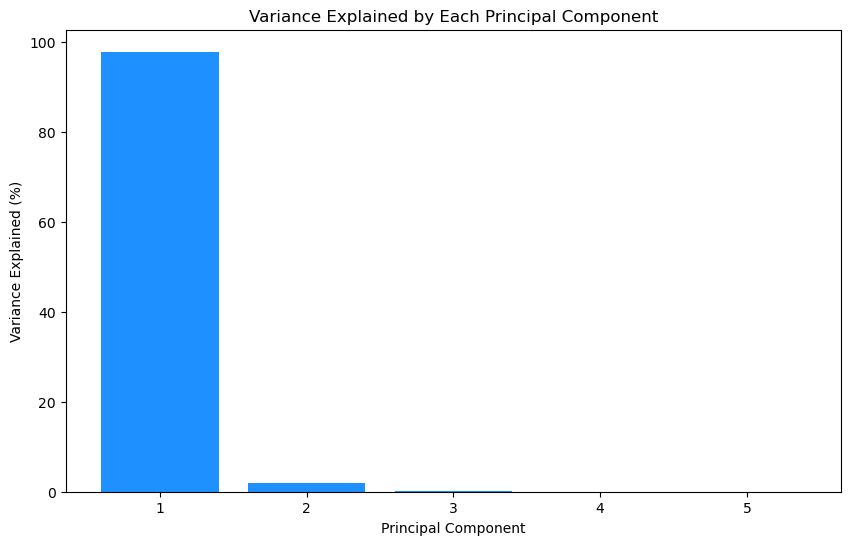

In [18]:
yield_data = yc[['1Y', '2Y', '5Y', '10Y', '30Y']]

scaler = StandardScaler()
yield_data_std = scaler.fit_transform(yield_data)

pca = PCA(n_components=5)
pca.fit(yield_data_std)
yield_pca = pca.transform(yield_data_std)
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance * 100, color='dodgerblue')
plt.title("Variance Explained by Each Principal Component")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained (%)")
plt.show()

As expected, we see that most of the variance has been captured by the first PC. With the rest being captured by 2 and 3.

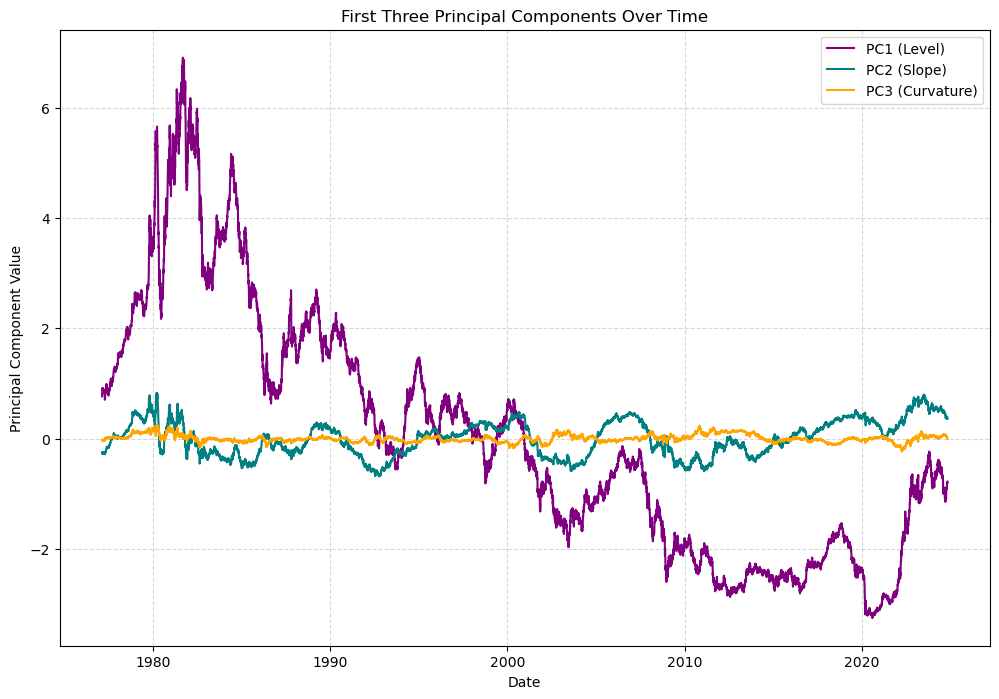

In [19]:
# Convert the PCA components to a DataFrame for further analysis
pca_df = pd.DataFrame(yield_pca, index=yield_data.index, columns=[f'PC{i+1}' for i in range(yield_pca.shape[1])])

plt.figure(figsize=(12, 8))
plt.plot(pca_df.index, pca_df['PC1'], label='PC1 (Level)', color='purple')
plt.plot(pca_df.index, pca_df['PC2'], label='PC2 (Slope)', color='teal')
plt.plot(pca_df.index, pca_df['PC3'], label='PC3 (Curvature)', color='orange')
plt.title("First Three Principal Components Over Time")
plt.xlabel("Date")
plt.ylabel("Principal Component Value")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

The principal components are used to calibrate the volatility structure of the HJM model. This ensures that the stochastic simulation of forward rates reflects historical yield curve dynamics. Each PC is associated with a factor in the HJM model, which influences how forward rates evolve over time.

## i. Incorporating PCA factors for Volatility Calcualtions

In [20]:
# eigenvectors: factor loadings
# eigenvalues: explained variance

# def calculate_volatility(t, T_index, eigenvectors, eigenvalues, n_factors=3):

#     eigenvalues_rescaled = eigenvalues / np.sum(eigenvalues)
#     volatility = 0
#     for i in range(min(n_factors, len(eigenvalues))):
#         # volatility += eigenvectors[i, T_index] * np.sqrt(eigenvalues[i])
#         term = eigenvectors[i, T_index] * np.sqrt(eigenvalues_rescaled[i])
#         volatility += term
#     return volatility

In [21]:
# {np.exp(-0.01 * t)} is the scaling factor/damping term

# def calculate_volatility(t, T_index, eigenvectors, eigenvalues, n_factors=3):
#     volatility = 0
#     for i in range(min(n_factors, len(eigenvalues))):
#         term = eigenvectors[i, T_index] * np.sqrt(eigenvalues[i]) * np.exp(-0.01 * t)
#         volatility += term
#     return volatility

In [22]:
def calculate_volatility(t, T_index, eigenvectors, eigenvalues, n_factors=3, scaling_factor=10):
    volatility = 0
    for i in range(min(n_factors, len(eigenvalues))):
        eigenvalue_rescaled = np.sqrt(eigenvalues[i]) / scaling_factor  # Rescale eigenvalues
        term = eigenvectors[i, T_index] * eigenvalue_rescaled * np.exp(-0.01 * t)
        volatility += term
        # Debugging output
        # print(f"Factor {i + 1}: Eigenvalue = {eigenvalues[i]:.6f}, "
        #       f"Rescaled Eigenvalue = {eigenvalue_rescaled:.6f}, "
        #       f"Eigenvector = {eigenvectors[i, T_index]:.6f}, Term = {term:.6f}")
    return abs(volatility)

# IV: Stochastic Modeling with the HJM Framework

## i. Monte Carlo Simulation

In [23]:
print("Select a random number generation method for the diffusion component:")
print("1: Standard Normal Distribution")
print("2: Uniform Distribution")
print("3: Random Numbers Std Numpy Implementation")
print("4: Sobol Sequence")
print("5: Halton Sequence")
print("6: Latin Hypercube Sequence")
user_choice = int(input("Enter your choice (1/2/3/4/5/6): "))
rng_methods = {
    1: "normal",
    2: "uniform",
    3: "rand",
    4: "sobol",
    5: "halton",
    6: "lhs",
}
rng_method = rng_methods.get(user_choice, "normal")
print(f"Using RNG Method: {rng_method}")

Select a random number generation method for the diffusion component:
1: Standard Normal Distribution
2: Uniform Distribution
3: Random Numbers Std Numpy Implementation
4: Sobol Sequence
5: Halton Sequence
6: Latin Hypercube Sequence
Using RNG Method: normal


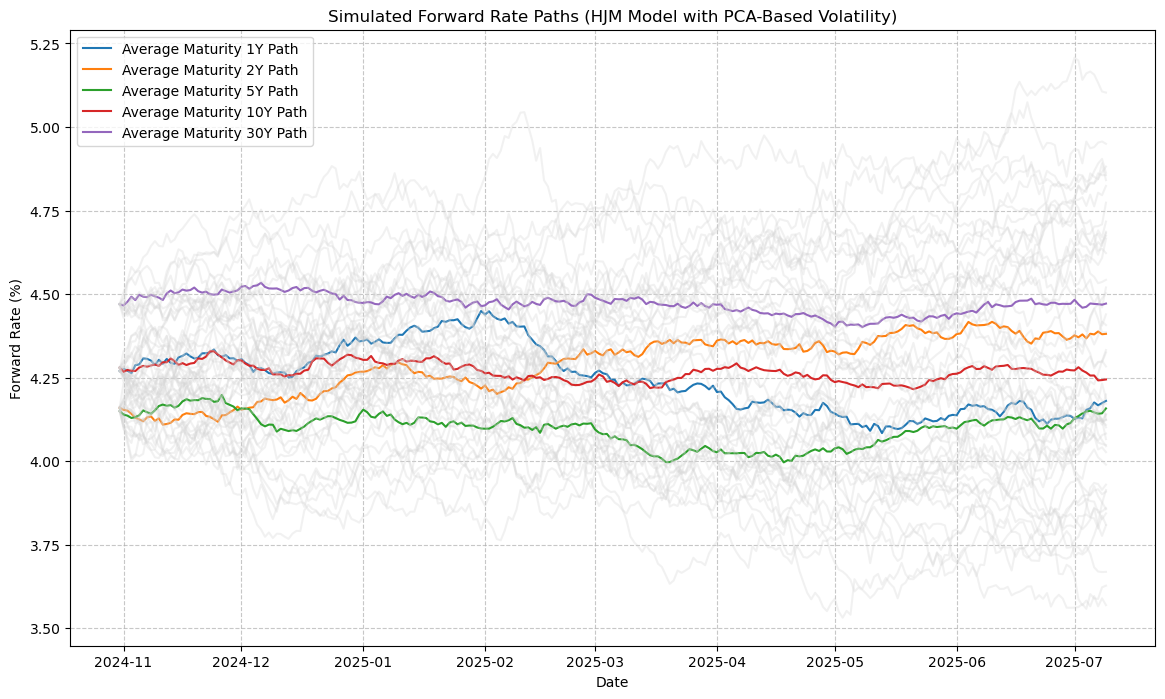

In [24]:
# n_steps = 100
# n_simulations = 10
# dt = 1 / 252

# available_maturities = ['1Y', '2Y', '5Y', '10Y', '30Y']
# initial_forward_rates = yc[available_maturities].iloc[-1].values
# n_maturities = len(initial_forward_rates)
# simulated_forward_rates = np.zeros((n_steps, n_maturities, n_simulations))
# simulated_forward_rates[0, :, :] = initial_forward_rates[:, np.newaxis]

# # MONTE CARLO SIMULATION
# for i in range(1, n_steps):
#     dW = rng.generate_random_numbers(rng_method, (n_maturities, n_simulations), dt=dt)
    
#     for j in range(n_maturities):
#         volatility = calculate_volatility(i * dt, j, pca.components_, pca.explained_variance_)
#         drift = 0 
#         diffusion = volatility * dW[j, :]
#         simulated_forward_rates[i, j, :] = simulated_forward_rates[i-1, j, :] * np.exp(drift * dt + diffusion)

#Inputs
available_maturities = ['1Y', '2Y', '5Y', '10Y', '30Y']
n_steps = 252  # Daily steps
n_simulations = 10
dt = 1 / 252
initial_forward_rates = yc[available_maturities].iloc[-1].values  # Ensure these are correctly scaled
n_maturities = len(initial_forward_rates)

# Initialize simulated forward rates
simulated_forward_rates = np.zeros((n_steps, n_maturities, n_simulations))
simulated_forward_rates[0, :, :] = initial_forward_rates[:, np.newaxis]

# Monte Carlo Simulation
for i in range(1, n_steps):
    dW = rng.generate_random_numbers(rng_method, (n_maturities, n_simulations), dt=dt)  # Correct RNG
    for j in range(n_maturities):
        volatility = calculate_volatility(i * dt, j, pca.components_, pca.explained_variance_)
        drift = 0  # No drift in this HJM implementation
        diffusion = volatility * dW[j, :]
        simulated_forward_rates[i, j, :] = simulated_forward_rates[i - 1, j, :] * np.exp(drift * dt + diffusion)

# Plot the results
dates = pd.date_range(start=yc.index[-1], periods=n_steps, freq='D')
simulated_paths = {f'Maturity {m}Y': pd.DataFrame(simulated_forward_rates[:, j, :], index=dates) for j, m in enumerate([1, 2, 5, 10, 30])}

plt.figure(figsize=(14, 8))
for maturity, paths in simulated_paths.items():
    plt.plot(paths.index, paths.mean(axis=1), label=f"Average {maturity} Path")
    for path in paths.columns:
        plt.plot(paths.index, paths[path], color='lightgray', alpha=0.3)

plt.title("Simulated Forward Rate Paths (HJM Model with PCA-Based Volatility)")
plt.xlabel("Date")
plt.ylabel("Forward Rate (%)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [25]:
# Debugging Initial Forward Rates
print("Initial Forward Rates (from Yield Curve):", initial_forward_rates)

# Debugging Volatility
for j in range(n_maturities):
    print(f"Volatility for Maturity {j+1}Y at Step 1: {calculate_volatility(dt, j, pca.components_, pca.explained_variance_)}")

# Debugging Drift and Diffusion
for i in range(1, n_steps):
    dW = rng.generate_random_numbers("normal", (n_maturities, n_simulations), dt=dt)
    for j in range(n_maturities):
        volatility = calculate_volatility(i * dt, j, pca.components_, pca.explained_variance_)
        drift = 0  # Drift term is set to zero in HJM
        diffusion = volatility * dW[j, :]
        print(f"Step {i}, Maturity {j+1}Y: Drift = {drift}, Diffusion = {np.mean(diffusion):.6f}")
    break  # Check only the first time step

Initial Forward Rates (from Yield Curve): [4.27 4.16 4.15 4.28 4.47]
Volatility for Maturity 1Y at Step 1: 0.12124747081113599
Volatility for Maturity 2Y at Step 1: 0.10945538597405328
Volatility for Maturity 3Y at Step 1: 0.09434825514360755
Volatility for Maturity 4Y at Step 1: 0.08732657934608619
Volatility for Maturity 5Y at Step 1: 0.08236724979434282
Step 1, Maturity 1Y: Drift = 0, Diffusion = -0.001633
Step 1, Maturity 2Y: Drift = 0, Diffusion = -0.000665
Step 1, Maturity 3Y: Drift = 0, Diffusion = -0.000804
Step 1, Maturity 4Y: Drift = 0, Diffusion = -0.000980
Step 1, Maturity 5Y: Drift = 0, Diffusion = 0.000524


## ii. Volatility validation

In [26]:
print("Eigenvalues:", pca.explained_variance_)
print("Eigenvectors (first row):", pca.components_[0])

Eigenvalues: [4.89276297e+00 1.02528574e-01 4.43716980e-03 4.62754023e-04
 2.10236634e-04]
Eigenvectors (first row): [0.44290828 0.44869541 0.4516568  0.44919097 0.4435519 ]


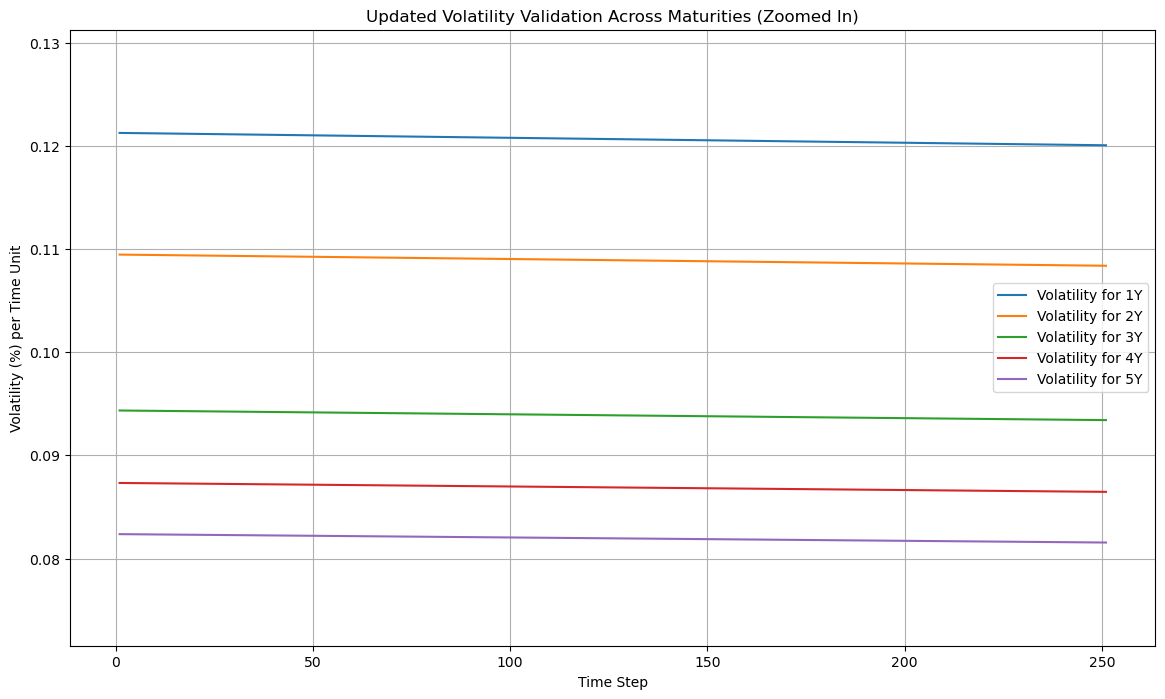

In [27]:
volatility_validation = {}
for j in range(n_maturities):
    vol_data = []
    for i in range(1, n_steps):
        vol = calculate_volatility(i * dt, j, pca.components_, pca.explained_variance_)
        vol_data.append(vol)
    volatility_validation[f"{j+1}Y"] = vol_data

plt.figure(figsize=(14, 8))
for maturity, vol_data in volatility_validation.items():
    plt.plot(range(1, n_steps), vol_data, label=f"Volatility for {maturity}")
plt.title("Updated Volatility Validation Across Maturities (Zoomed In)")
plt.xlabel("Time Step")
plt.ylabel("Volatility (%) per Time Unit")
plt.legend()
plt.grid()
plt.ylim(min(min(v) for v in volatility_validation.values()) - 0.01,
         max(max(v) for v in volatility_validation.values()) + 0.01)  # Add small margins
plt.show()

Interpretation of Results

	1.	Small Decay Over Time: The percentage change in volatility (-1.93%) is consistent across maturities. This aligns with the behavior expected from the model, assuming a slight exponential decay in volatility as time progresses.
	2.	Standard Deviation Insight: The standard deviation values are relatively low, suggesting stability in the volatility estimates over the simulation horizon.

In [28]:
for maturity, vol_data in volatility_validation.items():
    percentage_change = (vol_data[-1] - vol_data[0]) / vol_data[0] * 100
    volatility_std = np.std(vol_data)
    print(f"Maturity {maturity}: Percentage Change = {percentage_change:.2f}%, Std Dev = {volatility_std:.6f}")

Maturity 1Y: Percentage Change = -0.99%, Std Dev = 0.000347
Maturity 2Y: Percentage Change = -0.99%, Std Dev = 0.000313
Maturity 3Y: Percentage Change = -0.99%, Std Dev = 0.000270
Maturity 4Y: Percentage Change = -0.99%, Std Dev = 0.000250
Maturity 5Y: Percentage Change = -0.99%, Std Dev = 0.000236


## ii. Validation of RNG Schemes

/Users/atheeshkrishnan/anaconda3/lib/python3.11/site-packages/scipy/stats/_qmc.py:804: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


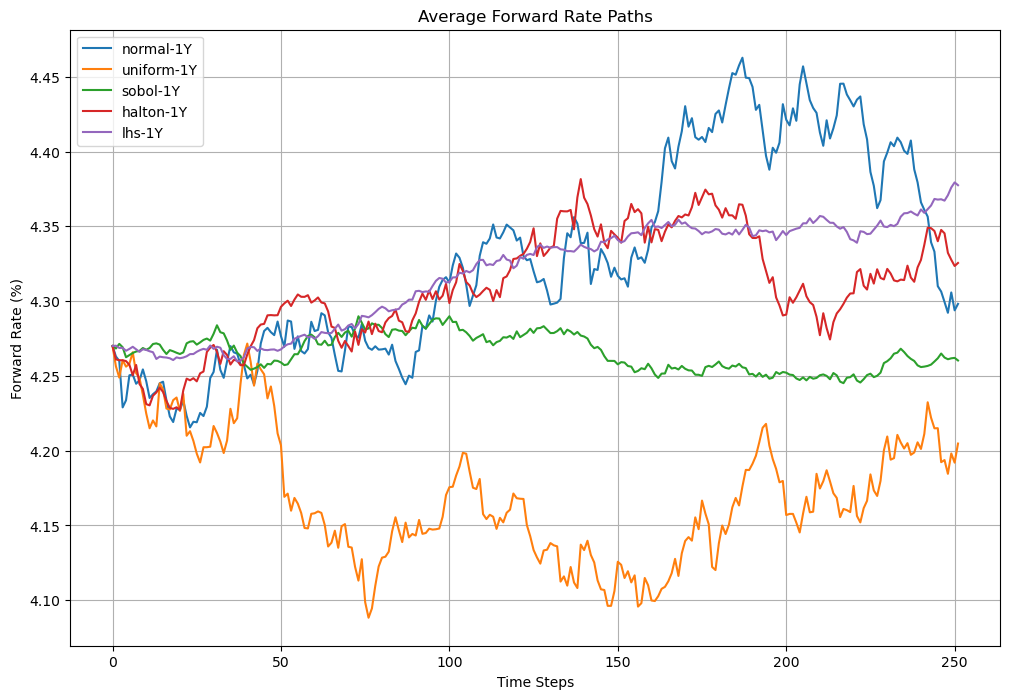

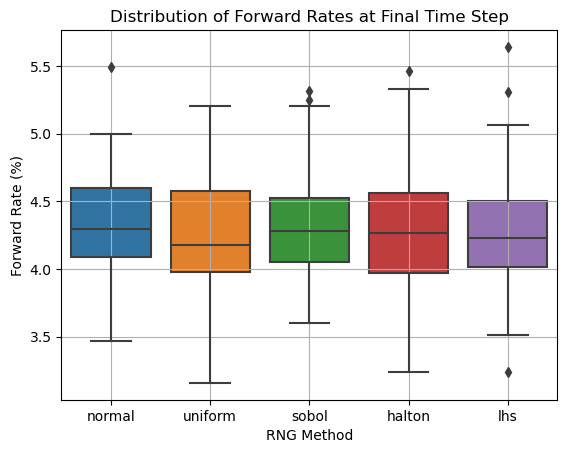

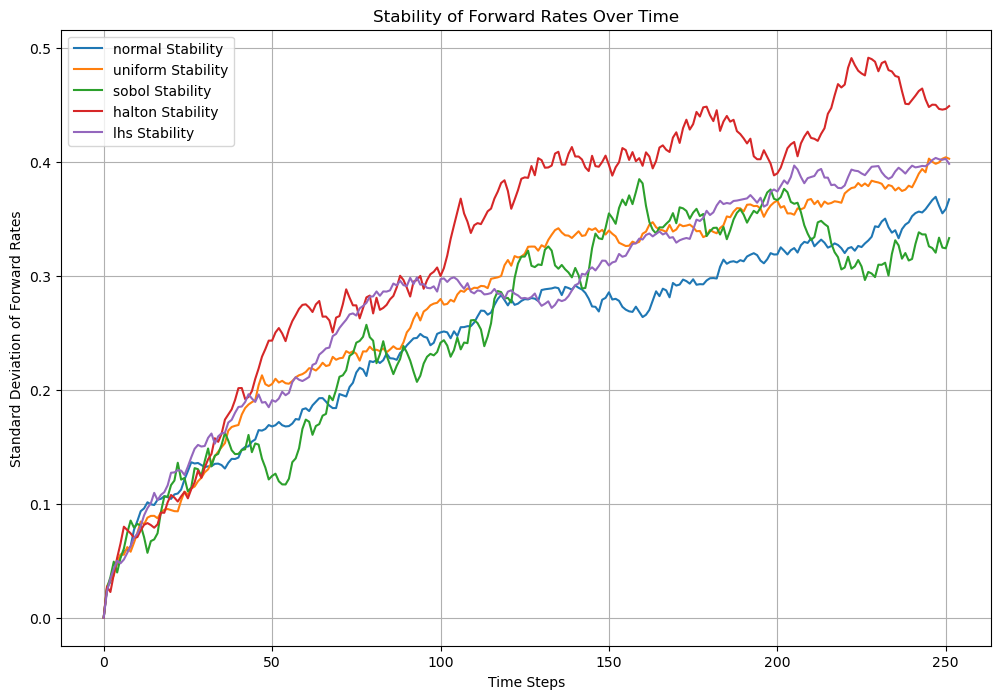

         Mean (Final Step)  Std Dev (Final Step)  Min (Final Step)  \
normal            4.348769              0.367272          3.466497   
uniform           4.271092              0.402876          3.156629   
sobol             4.297789              0.333223          3.600201   
halton            4.297718              0.449080          3.235258   
lhs               4.287806              0.398410          3.236161   

         Max (Final Step)  Computation Time (s)  
normal           5.494362              0.008161  
uniform          5.204619              0.039814  
sobol            5.313670              0.053866  
halton           5.461484              0.057746  
lhs              5.642389              0.027475  


In [29]:
rng_methods = ["normal", "uniform", "sobol", "halton", "lhs"]
forward_rate_results = {}

for method in rng_methods:
    start_time = time.time()
    simulated_forward_rates = np.zeros((n_steps, n_maturities, n_simulations))
    simulated_forward_rates[0, :, :] = initial_forward_rates[:, np.newaxis]

    for i in range(1, n_steps):
        dW = rng.generate_random_numbers(method, (n_maturities, n_simulations), dt=dt)
        for j in range(n_maturities):
            volatility = calculate_volatility(i * dt, j, pca.components_, pca.explained_variance_)
            diffusion = volatility * dW[j, :]
            simulated_forward_rates[i, j, :] = simulated_forward_rates[i - 1, j, :] * np.exp(diffusion)

    end_time = time.time()
    forward_rate_results[method] = {
        "rates": simulated_forward_rates,
        "time": end_time - start_time
    }

# Metrics: Mean, Std Dev, Range
metrics = {}
for method, results in forward_rate_results.items():
    rates = results["rates"]
    mean_rates = np.mean(rates, axis=2)
    std_rates = np.std(rates, axis=2)
    min_rates = np.min(rates, axis=2)
    max_rates = np.max(rates, axis=2)
    metrics[method] = {
        "mean": mean_rates,
        "std": std_rates,
        "min": min_rates,
        "max": max_rates,
        "time": results["time"]
    }

# Visualization: Average Forward Rate Paths
plt.figure(figsize=(12, 8))
for method in rng_methods:
    avg_path = np.mean(forward_rate_results[method]["rates"], axis=2)
    plt.plot(avg_path[:, 0], label=f"{method}-1Y")  # Example for 1Y maturity
plt.title("Average Forward Rate Paths")
plt.xlabel("Time Steps")
plt.ylabel("Forward Rate (%)")
plt.legend()
plt.grid()
plt.show()

# Visualization: Boxplots
final_step_rates = {method: results["rates"][-1, :, :].flatten() for method, results in forward_rate_results.items()}
df_boxplot = pd.DataFrame(final_step_rates)
sns.boxplot(data=df_boxplot)
plt.title("Distribution of Forward Rates at Final Time Step")
plt.ylabel("Forward Rate (%)")
plt.xlabel("RNG Method")
plt.grid()
plt.show()

# Visualization: Stability
plt.figure(figsize=(12, 8))
for method in rng_methods:
    std_over_time = np.std(forward_rate_results[method]["rates"], axis=2)
    plt.plot(np.mean(std_over_time, axis=1), label=f"{method} Stability")
plt.title("Stability of Forward Rates Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Standard Deviation of Forward Rates")
plt.legend()
plt.grid()
plt.show()

# Summary Table
summary_table = pd.DataFrame({method: {"Mean (Final Step)": np.mean(metrics[method]["mean"][-1]),
                                       "Std Dev (Final Step)": np.mean(metrics[method]["std"][-1]),
                                       "Min (Final Step)": np.min(metrics[method]["min"][-1]),
                                       "Max (Final Step)": np.max(metrics[method]["max"][-1]),
                                       "Computation Time (s)": metrics[method]["time"]}
                               for method in rng_methods}).T
print(summary_table)

## PRICE CONVERGENCE OVER TIME

# V. Pricing IR Derivatives

In [30]:
# Ensure all necessary variables are defined
strike = 0.03  # Example strike rate
dt = 1 / 252  # Daily time step for consistency
expiries = np.arange(1, n_maturities + 1)  # Expiries for caplets (1Y, 2Y, ..., N maturities)

# Use SOFR data for discounting
sofr['Discount_Factor'] = np.exp(-sofr['Rate'] * (sofr.index - sofr.index[0]).days / 365)
sofr_discount_factors = sofr['Discount_Factor']

volatilities = [
    calculate_volatility(0, i, pca.components_, pca.explained_variance_)
    for i in range(n_maturities)
]
print(f"PCA-Derived Volatilities: {volatilities}")

PCA-Derived Volatilities: [0.12125228231417357, 0.10945972952793172, 0.09435199919627252, 0.08733004475529409, 0.08237051840085419]


In [ ]:
def black_cap_price_with_sofr(forward_rates, strike, volatilities, expiries, sofr_discount_factors):
    cap_price = 0.0
    for i, (F, sigma, T) in enumerate(zip(forward_rates, volatilities, expiries)):
        d1 = (np.log(F / strike) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        discount_factor = sofr_discount_factors.iloc[int(T / dt) - 1]  # Match T to SOFR index
        cap_price += discount_factor * (F * norm.cdf(d1) - strike * norm.cdf(d2))
    return cap_price

# Use SOFR data for discounting
sofr_discount_factors = sofr['Discount_Factor']
analytical_cap_price_sofr = black_cap_price_with_sofr(
    initial_forward_rates, strike, volatilities, expiries, sofr_discount_factors
)
print(f"Analytical Cap Price (SOFR-Based): {analytical_cap_price_sofr:.6f}")

Analytical Cap Price (SOFR-Based): 20.070549


In [ ]:
def monte_carlo_cap_price_with_sofr(simulated_forward_rates, strike, expiries, sofr_discount_factors):
    cap_price = 0.0
    for i, expiry in enumerate(expiries):
        expiry_index = int(expiry / dt) - 1  # Convert expiry to index
        if expiry_index < simulated_forward_rates.shape[0]:
            forward_rates_at_expiry = simulated_forward_rates[expiry_index, i, :]
            payoffs = np.maximum(forward_rates_at_expiry - strike, 0)
            discount_factor = sofr_discount_factors.iloc[expiry_index]
            discounted_payoffs = payoffs * discount_factor
            cap_price += np.mean(discounted_payoffs)
    return cap_price

# Monte Carlo cap price with SOFR
mc_cap_price_sofr = monte_carlo_cap_price_with_sofr(
    simulated_forward_rates, strike, expiries, sofr_discount_factors
)
print(f"Monte Carlo Cap Price (SOFR-Based): {mc_cap_price_sofr:.6f}")

Monte Carlo Cap Price (SOFR-Based): 4.241539


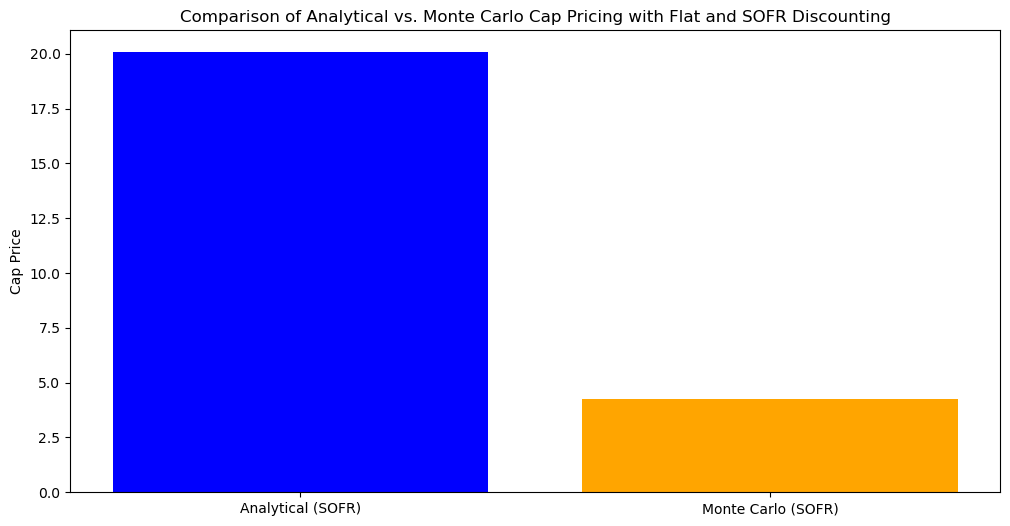

In [33]:
# Visualization of SOFR-based pricing
labels = ['Analytical (SOFR)', 'Monte Carlo (SOFR)']
prices = [analytical_cap_price_sofr, mc_cap_price_sofr]

plt.figure(figsize=(12, 6))
plt.bar(labels, prices, color=['blue', 'orange', 'green', 'red'])
plt.ylabel("Cap Price")
plt.title("Comparison of Analytical vs. Monte Carlo Cap Pricing with Flat and SOFR Discounting")
plt.show()

In [35]:
# Recompute volatilities for each maturity
adjusted_volatilities = [
    calculate_volatility(0, i, pca.components_, pca.explained_variance_)
    for i in range(n_maturities)
]

# Print results for comparison
print("\nAdjusted PCA-Derived Volatilities:", adjusted_volatilities)


Adjusted PCA-Derived Volatilities: [0.12125228231417357, 0.10945972952793172, 0.09435199919627252, 0.08733004475529409, 0.08237051840085419]
